# Bone Metastasis Classification using ResNet

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Load Data

In [2]:
# Set seed for PyTorch random number generation to create reproducible results
torch.manual_seed(5)

In [3]:
# Data augmentation and normalization according to the ResNet configuration
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
data_dir = 'dataset-sample-2/'
batch_size = 16
epochs = 100

In [5]:
image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir + 'train', data_transforms['train']),
    'test': 
    datasets.ImageFolder(data_dir + 'test', data_transforms['test'])
}

In [6]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0)
}

### Define Model

In [7]:
# Allocate tensors to the device used for computation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Performing torch operations on {device} device")

Performing torch operations on cpu device


In [8]:
# Load ResNet50 model
model = models.resnet50(pretrained=True).to(device)

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
for param in model.parameters():
    param.requires_grad = False

In [10]:
# Change last layer to output two classes
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)

In [11]:
# Define criterion (function used to compute loss) and optimizer for model
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

### Train Model

In [12]:
train_losses = []
test_losses = []

In [13]:
def train_model(model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                test_losses.append(epoch_loss)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [14]:
model_trained = train_model(model, criterion, optimizer, epochs)

Epoch 1/100
----------
train loss: 0.7028, acc: 0.5000
test loss: 0.7191, acc: 0.3750
Epoch 2/100
----------
train loss: 0.7067, acc: 0.5000
test loss: 0.7164, acc: 0.3750
Epoch 3/100
----------
train loss: 0.6913, acc: 0.5000
test loss: 0.7167, acc: 0.3750
Epoch 4/100
----------
train loss: 0.6806, acc: 0.7000
test loss: 0.7127, acc: 0.3750
Epoch 5/100
----------
train loss: 0.6910, acc: 0.4000
test loss: 0.7091, acc: 0.3750
Epoch 6/100
----------
train loss: 0.6703, acc: 0.6000
test loss: 0.7085, acc: 0.3750
Epoch 7/100
----------
train loss: 0.6808, acc: 0.5000
test loss: 0.7131, acc: 0.3750
Epoch 8/100
----------
train loss: 0.6868, acc: 0.6000
test loss: 0.7156, acc: 0.3750
Epoch 9/100
----------
train loss: 0.6698, acc: 0.8000
test loss: 0.7140, acc: 0.3750
Epoch 10/100
----------
train loss: 0.6922, acc: 0.6000
test loss: 0.7117, acc: 0.5000
Epoch 11/100
----------
train loss: 0.6787, acc: 0.5000
test loss: 0.7087, acc: 0.6250
Epoch 12/100
----------
train loss: 0.6379, acc: 0.8

train loss: 0.4347, acc: 0.8000
test loss: 0.7386, acc: 0.5000
Epoch 96/100
----------
train loss: 0.4266, acc: 0.9000
test loss: 0.7351, acc: 0.5000
Epoch 97/100
----------
train loss: 0.4296, acc: 0.9000
test loss: 0.7389, acc: 0.5000
Epoch 98/100
----------
train loss: 0.4593, acc: 0.7000
test loss: 0.7394, acc: 0.5000
Epoch 99/100
----------
train loss: 0.4854, acc: 0.9000
test loss: 0.7473, acc: 0.5000
Epoch 100/100
----------
train loss: 0.5667, acc: 0.7000
test loss: 0.7549, acc: 0.5000


### Save Model

In [15]:
torch.save(model_trained.state_dict(), 'weights/resnet_weights.h5')

In [16]:
model = models.resnet50(weights=None).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('weights/resnet_weights.h5'))

<All keys matched successfully>

### Evaluate Model

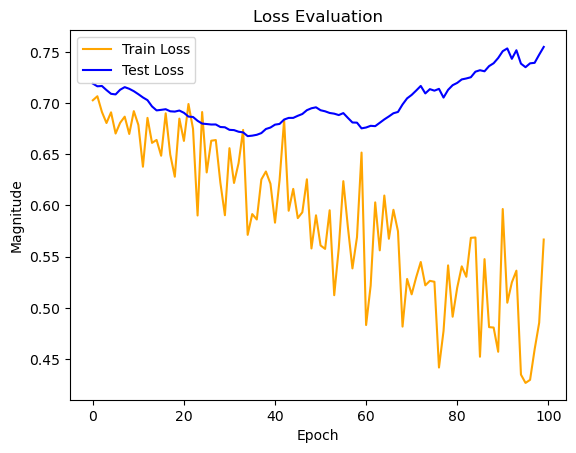

In [25]:
# Plot losses
ax = plt.axes()
plt.plot(train_losses, color='orange')
plt.plot(test_losses, color='blue')
plt.title('Loss Evaluation')
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [17]:
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
total = 0

with torch.no_grad():
    for batch_index, batch_data in enumerate(dataloaders['test']):
        # Get the inputs; data is a list of [images, labels]
        images, labels = batch_data

        # Forward pass
        predictions = model(images)

        # Set total and correct
        _, predicted = torch.max(input=predictions, dim=1) # Get list of predicted classes
            
        # Get how many classes there were in this batch
        total += labels.size(0)
            
        # Get true positive, true negative, false positive, and false negative counts
        for index in range(len(labels)):
            true_pos = true_pos+1 if (predicted[index] == 1 and labels[index] == 1) else true_pos
            true_neg = true_neg+1 if (predicted[index] == 0 and labels[index] == 0) else true_neg
            false_pos = false_pos+1 if (predicted[index] == 1 and labels[index] == 0) else false_pos
            false_neg = false_neg+1 if (predicted[index] == 0 and labels[index] == 1) else false_neg
    
print(f"TP: {true_pos}, TN: {true_neg}, FP: {false_pos}, FN: {false_neg}, total: {total}")
    
# Get performance metrics
# accuracy: (tp + tn) / (p + n)
accuracy = (true_pos + true_neg)/total if total != 0 else 0
print(f"Accuracy: {accuracy}")
    
# precision tp / (tp + fp)
precision = true_pos/(true_pos + false_pos) if (true_pos + false_pos) != 0 else 0
print(f"Precision: {precision}")
    
# sensitivity: tp / (tp + fn)
sensitivity = true_pos/(true_pos + false_neg) if (true_pos + false_neg) != 0 else 0
print(f"Sensitivity: {sensitivity}")
    
# specificity: tn / (tn + fp)
specificity = true_neg/(true_neg + false_pos) if (true_neg + false_pos) != 0 else 0
print(f"Specificity: {specificity}")
    
# f1: 2(precision * recall)/(precision + recall)
f1 = 2 * (precision * sensitivity)/(precision + sensitivity) if (precision + sensitivity) != 0 else 0
print(f"F1: {f1}")

TP: 2, TN: 1, FP: 2, FN: 3, total: 8
Accuracy: 0.375
Precision: 0.5
Sensitivity: 0.4
Specificity: 0.3333333333333333
F1: 0.4444444444444445


In [18]:
# Get computational complexity
from torchstat import stat
stat(model, (3, 646, 220))

[MAdd]: AdaptiveAvgPool2d is not supported!
[Flops]: AdaptiveAvgPool2d is not supported!
[Memory]: AdaptiveAvgPool2d is not supported!
                 module name   input shape  output shape      params memory(MB)              MAdd             Flops  MemRead(B)  MemWrite(B) duration[%]    MemR+W(B)
0                      conv1     3 646 220    64 323 110      9408.0       8.67     666,258,560.0     334,266,240.0   1743072.0    9095680.0       2.05%   10838752.0
1                        bn1    64 323 110    64 323 110       128.0       8.67       9,095,680.0       4,547,840.0   9096192.0    9095680.0       0.68%   18191872.0
2                       relu    64 323 110    64 323 110         0.0       8.67       2,273,920.0       2,273,920.0   9095680.0    9095680.0       0.00%   18191360.0
3                    maxpool    64 323 110    64 162  55         0.0       2.18       4,561,920.0       2,273,920.0   9095680.0    2280960.0       2.57%   11376640.0
4             layer1.0.conv1    64 

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


### Show Predictions on Sample Images

In [19]:
test_img_paths = [data_dir + "test/0/" + "0000-0-A.tif",
                  data_dir + "test/1/" + "0006-1-A.tif",
                  data_dir + "test/0/" + "0002-0-A.tif"]
test_ground_truths = ["No Metastasis", "Metastasis", "No Metastasis"]
img_list = [Image.open(img_path) for img_path in test_img_paths]

In [20]:
validation_batch = torch.stack([data_transforms['test'](img).to(device) for img in img_list])

In [21]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

[MAdd]: AdaptiveAvgPool2d is not supported!
[Flops]: AdaptiveAvgPool2d is not supported!
[Memory]: AdaptiveAvgPool2d is not supported!


tensor([[-0.6128,  0.3686],
        [ 0.2465, -0.1744],
        [ 0.7930, -0.6194]], grad_fn=<AddmmBackward0>)

In [22]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.2726238 , 0.7273762 ],
       [0.6036938 , 0.39630625],
       [0.80415106, 0.19584891]], dtype=float32)

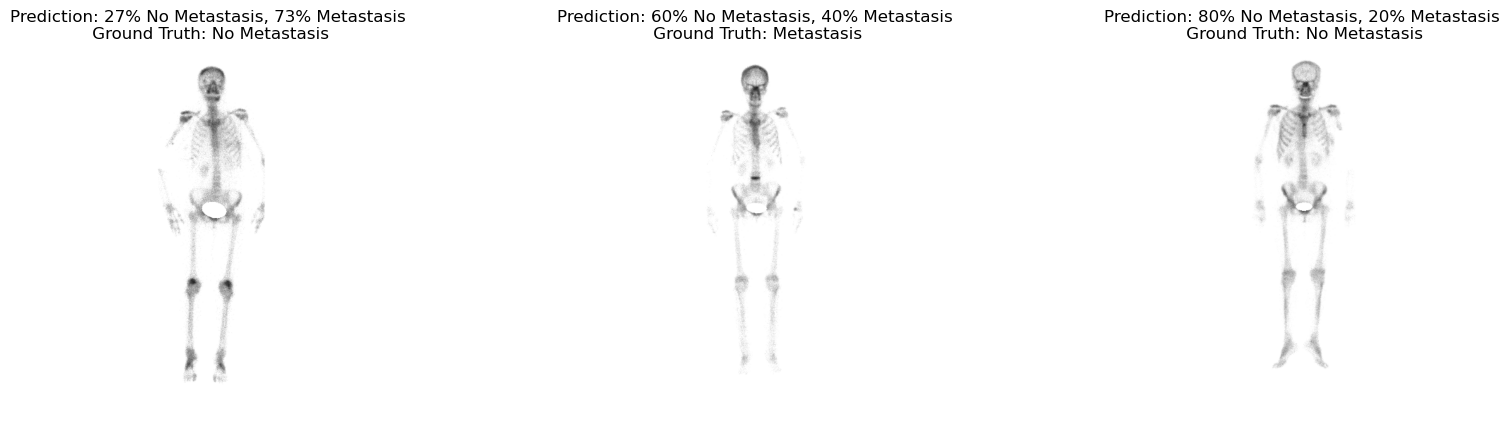

In [23]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("Prediction: {:.0f}% No Metastasis, {:.0f}% Metastasis\n Ground Truth: {}"
                 .format(100*pred_probs[i,0], 100*pred_probs[i,1], test_ground_truths[i]))
    ax.imshow(img)